# Group 1 - Data Mining Project: Recommendation Systems
## Evaluating: SVD, BPR, T4Rec



### System level installations

Upgrade our pip environment to ensure we have access to the latest pip packages on pypi.

In [ ]:
!python3 -m pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


Install python dependencies

In [ ]:
!python3 -m pip install \
datasets \
implicit \
matplotlib \
pillow \
scikit-surprise \
tqdm

Wget yaml config files into the workspace

In [ ]:
#!wget <insert raw url here>

### Project imports

In [101]:
import gzip
import math
import os
import random
import requests
import time
from tempfile import TemporaryDirectory
from urllib.request import urlretrieve
from zipfile import ZipFile

import numpy as np
import pandas as pd
import scipy
# import torch
from io import BytesIO
from PIL import Image
# from torch import nn, Tensor
# from torch.nn import TransformerEncoder, TransformerEncoderLayer
# from torch.nn.utils.rnn import pad_sequence
# from torch.utils.data import DataLoader as torch_dl
# from torch.utils.data import Dataset as torch_ds
from collections import Counter, defaultdict
from datasets import load_dataset, Dataset as DS
from implicit import bpr
from implicit.evaluation import train_test_split as bpr_train_test_split
from implicit.evaluation import leave_k_out_split, precision_at_k, AUC_at_k, ndcg_at_k, ranking_metrics_at_k
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

from matplotlib import pyplot as plt
from tqdm import tqdm
from typing import Tuple

### Data Loading: Load the Amazon reviews dataset from Huggingface

In [5]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Musical_Instruments", trust_remote_code=True)
print(dataset["full"][0])
dataset_items = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Musical_Instruments", trust_remote_code=True)
print(dataset_items["full"][0])

#Print our splits
print(dataset.keys())
print(len(dataset["full"]))
print(dataset_items.keys())
print(len(dataset_items["full"]))

{'rating': 5.0, 'title': 'Five Stars', 'text': 'Great headphones, comfortable and sound is good. No complaints. I would buy again.', 'images': [], 'asin': 'B003LPTAYI', 'parent_asin': 'B003LPTAYI', 'user_id': 'AGKASBHYZPGTEPO6LWZPVJWB2BVA', 'timestamp': 1452650586000, 'helpful_vote': 0, 'verified_purchase': True}
{'main_category': 'Musical Instruments', 'title': 'Pearl Export Lacquer EXL725S/C249 5-Piece New Fusion Drum Set with Hardware, Honey Amber', 'average_rating': 4.2, 'rating_number': 22, 'features': ['Item may ship in more than one box and may arrive separately', '(22x18, 10x7, 12x8, 16x16, 14x5.5)', 'P930 Demonator Pedal', '830 Hardware Pack', 'Matching snare, REMO snare batter side head'], 'description': ["Introducing the best selling drum set of all time... Export Series returns and this time with a lacquer finish. EXL Export Lacquer Series incorporates Pearl's S.S.T. Superior Shell Technology, Opti-Loc tom mounts, all-new 830 Series Hardware with a P-930 Pedal, and a choice

### Load the dataset into a pandas dataframe

In [6]:
# Dataframe for training
random_state = 33
df = pd.DataFrame(dataset['full'][:len(dataset['full']) // 10]).sample(frac=0.5, random_state=random_state)
print(df.head())
print(df.dtypes)

        rating                   title  \
36861      5.0              Five Stars   
36728      4.0          My first baton   
142396     5.0             Works Great   
83052      3.0  Good sound with issues   
218173     5.0     Quality made cable.   

                                                     text images        asin  \
36861                           Favorite headphones ever!     []  B003LPTAYI   
36728   Nicely made, pleasant balance. I haven't seen ...     []  B000EEJIV4   
142396  Works fine with older Casio WK-1200.  More erg...     []  B019SKINGA   
83052   I had pops, modulation and a white noise issue...     []  B01AUSB4ZQ   
218173                                       Works great.     []  B07RGP5WYL   

       parent_asin                       user_id      timestamp  helpful_vote  \
36861   B003LPTAYI  AHEW4RN4A7C5DZKQ3V3C5WIIDHJQ  1489184381000             0   
36728   B000EEJIV4  AG43EYXSK76E5O6KIOH7EYC2KASA  1366828748000             0   
142396  B019SKINGA  AE2

In [7]:
# Initialize the reader object with a rating scale between 1 and 5
reader = Reader(rating_scale=(1, 5))

# Load the dataframe content observing title, text, and rating
surprise_data = Dataset.load_from_df(df[['user_id', 'parent_asin', 'rating']], reader)

In [8]:
# Create an items dataframe
df_items = pd.DataFrame(dataset_items['full'])

In [9]:
# userIDs is a map from user_id to index
# itemIDS is a map from item_id to index
# indexToUser is a map from the index to the user ID
# indexToItem is a map from the index to the item ID
# asinToParentAsin is a map from asin to parent asin (item ID of all variants)
userIDs, itemIDs, indexToUser, indexToItem, parentIDs, indexToParent, asinToParentAsin = {}, {}, {}, {}, {}, {}, {}

for idx, row in tqdm(df.iterrows()):
    user_id, item_id, parent_item_id = row["user_id"], row["asin"], row["parent_asin"]
    if user_id not in userIDs:
        userIDs[user_id] = len(userIDs)
        indexToUser[userIDs[user_id]] = user_id
    if item_id not in itemIDs:
        itemIDs[item_id] = len(itemIDs)
        indexToItem[itemIDs[item_id]] = item_id
        asinToParentAsin[item_id] = parent_item_id
    if parent_item_id not in parentIDs:
        parentIDs[parent_item_id] = len(parentIDs)
        indexToParent[parentIDs[parent_item_id]] = parent_item_id


nUsers, nItems, nParents = len(userIDs), len(itemIDs), len(parentIDs)
print(f"There are a total of {nUsers} users and {nParents} products with a total of {nItems} items including all variants.")

150872it [00:10, 14603.28it/s]

There are a total of 80440 users and 47852 products with a total of 56798 items including all variants.


# SVD Based Recommendation

In [10]:
# Number of latent factors
k = 5

# Initialize the Single Value Decomposition model for collaborative filtering
svd = SVD(n_factors = k, verbose = True)

#Split the data into training and test sets. Only use 25% of the data for speed.
trainset, testset = train_test_split(surprise_data, test_size=.25, random_state=random_state)

# Fit the model to the training set
svd.fit(trainset)

# Assign predictions to the test set of the trained model
predictions = svd.test(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [11]:
# root mean squared error
accuracy.rmse(predictions, verbose=True)

# A sample Prediction contains the user id (uid), item id(iid), actual rating (r_ui), estimated rating (est), and additional details (details).
(predictions[0])

RMSE: 1.1279


Prediction(uid='AHFFCP63UNK2HZOQJFJHVWAONKFQ', iid='B0B8M5FJ9W', r_ui=5.0, est=4.555149425610465, details={'was_impossible': False})

In [12]:
def get_top_n(predictions, n=3):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=3)

In [13]:
# Print the recommended items for the first user
uid0, iids = None, None
for uid, user_ratings in top_n.items():
    uid0 = uid
    iids = [iid for (iid, _) in user_ratings]
print(f"User id that we inspect: {uid0}")

User id that we inspect: AHQDYKP77D5ZFKU5TYD3TZWFLNTA


In [14]:
# Check the similarity between a user and their items latent factors

user_ids = trainset.all_users()  # This returns a list of all user ids
inner_user_id = random.choice(user_ids)
user_vector = svd.pu[inner_user_id]
raw_user_id = trainset.to_raw_uid(inner_user_id)

# Get the list of items (item_ids) from the trainset
item_ids = trainset.all_items()

preds = []
# Predict ratings for a specific user for all items
for item_id in item_ids:
    raw_item_id = trainset.to_raw_iid(item_id)
    preds.append(svd.predict(raw_user_id, raw_item_id))

# Extract the item IDs that have the highest predicted ratings
predicted_items = sorted(preds, key=lambda x: x.est, reverse=True)
# print(predicted_items[:5])

# Get the item IDs sorted by the predicted rating
for pred in predicted_items[:3]:
    inner_item_id = trainset.to_inner_iid(pred.iid)
    item_vector = svd.qi[inner_item_id]
    print(np.dot(user_vector, item_vector))

-0.010575810505877001
0.004717510981572203
0.08515043071615597


In [15]:
# Check what the user has reviewed
user0_reviews = DS.from_pandas(df).filter(lambda row: row["user_id"] == uid0)

Filter: 100%|██████████| 150872/150872 [00:03<00:00, 40630.16 examples/s]


In [16]:
user0_reviewed_items = user0_reviews["parent_asin"]
user0_reviewd_items_images = dataset_items.filter(lambda row: row["parent_asin"] in user0_reviewed_items)

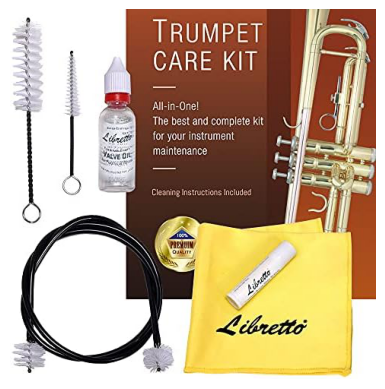

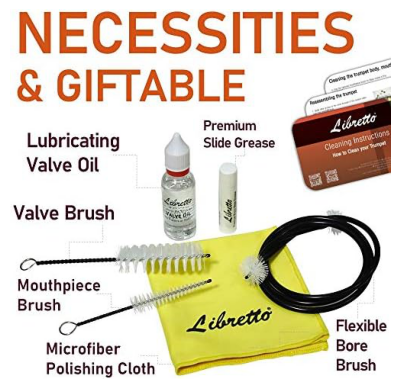

In [17]:
def show_images(dataset):
    image_urls = []
    # URL of the image
    for img in dataset["full"]["images"]:
        for large_image in img["large"][:2]: # show 2 images of each item that is recommended
            image_urls.append(large_image)

    for url in image_urls:
        # Fetch and display the image
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        # Display the image inline
        plt.imshow(img)
        plt.axis('off')  # Turn off axis labels
        plt.show()

show_images(user0_reviewd_items_images)

In [18]:
# Check what the model recommends for the user
uid0_images = []
filtered_dataset = dataset_items.filter(lambda row: row["parent_asin"] in iids)

filtered_dataset["full"].to_pandas().head()

main_category                                              title  \
0  Sports & Outdoors  Libretto Trumpet (Cornet) ALL-INCLUSIVE Care K...   

   average_rating  rating_number  \
0             4.7           2455   

                                            features description  price  \
0  [All-Inclusive Kit - Everything you need for i...          []  17.95   

                                              images  \
0  {'hi_res': ['https://m.media-amazon.com/images...   

                                              videos     store  \
0  {'title': ['Trumpet care kit', 'Libretto Trump...  Libretto   

                                          categories  \
0  [Musical Instruments, Instrument Accessories, ...   

                                             details parent_asin  \
0  {"Item Package Dimensions L x W x H": "5.98 x ...  B07DR9Z128   

  bought_together subtitle author  
0            None     None   None

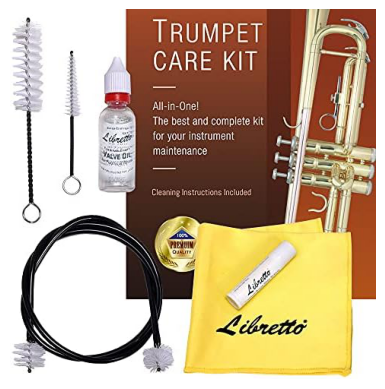

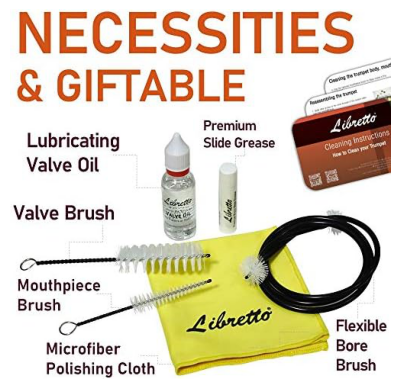

In [19]:
show_images(filtered_dataset)

### Recommendations for items and accessories that match with user's previous choices. Also, we have approximated the huge matrix with latent factors of much lower dimension!


In [97]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [98]:
precisions, recalls = precision_recall_at_k(predictions, k=3, threshold=4)

# Take the average over all values
precision = np.mean(np.array([prec for prec in precisions.values()]))
recall = np.mean(np.array([rec for rec in recalls.values()]))


print(f"Precision={precision}, recall={recall}")

Precision=0.7814919701749354, recall=0.7817999931154792


# Bayesian Personalized Ranking

### Preparation

In [23]:
# Create a new BPR dataframe
df_bpr = pd.DataFrame(dataset['full'][:len(dataset['full']) // 10]).sample(frac=.5, random_state=random_state)

random_state = 33

In [24]:
user_id_counts, parent_id_counts = defaultdict(int), defaultdict(int)
for idx, row in tqdm(df.iterrows()):
    user_id, item_id, parent_item_id = row["user_id"], row["asin"], row["parent_asin"]
    user_id_counts[user_id] += 1
    parent_id_counts[parent_item_id] += 1

150872it [00:10, 14966.78it/s]


In [44]:
df = df_bpr
threshold_users_list = [10, 20, 30, 35, 40]
threshold_parents_list = [25, 50, 75, 100, 125, 150]

bpr_precisions = []
bpr_aucs = []
bpr_ndcgs = []
threshold_pairs = []
models = []

for threshold_users in threshold_users_list:
    for threshold_parents in threshold_parents_list:
        # userIDs is a map from user_id to index
        # itemIDS is a map from item_id to index
        # indexToUser is a map from the index to the user ID
        # indexToItem is a map from the index to the item ID
        # asinToParentAsin is a map from asin to parent asin (item ID of all variants)
        # Assign our variables with empty dictionaries
        userIDs, itemIDs, indexToUser, indexToItem, parentIDs, indexToParent, asinToParentAsin = {}, {}, {}, {}, {}, {}, {}

        # Iterate over the dataframe rows
        for idx, row in tqdm(df.iterrows()):
            # Assign our variables to associations in our dataset
            user_id, item_id, parent_item_id = row["user_id"], row["asin"], row["parent_asin"]

            # Check if user_id is already in the dictionary, if not then assign it with a unique index
            if user_id not in userIDs and user_id_counts[user_id] >= threshold_users:
                userIDs[user_id] = len(userIDs)
                indexToUser[userIDs[user_id]] = user_id

            # Check item_ids inside the dictionary
            if item_id not in itemIDs:
                # Assign unique index to the item_id
                itemIDs[item_id] = len(itemIDs)
                # Map the index to the item
                indexToItem[itemIDs[item_id]] = item_id
                # Associate the item_id to the parent item id
                asinToParentAsin[item_id] = parent_item_id

            # Add the parent to the set of unique parentIDs
            if parent_item_id not in parentIDs and parent_id_counts[parent_item_id] >= threshold_parents:
                parentIDs[parent_item_id] = len(parentIDs)
                indexToParent[parentIDs[parent_item_id]] = parent_item_id


        # Get the lengths to print the totals
        nUsers, nItems, nParents = len(userIDs), len(itemIDs), len(parentIDs)
        print(f"For threshold_users = {threshold_users}, threshold_items = {threshold_parents}, there are a total of {nUsers} users and {nParents} products with a total of {nItems} items including all variants.")

        # Initialized after extracting the number of users and items
        Xui = scipy.sparse.lil_matrix((nUsers, nParents))

        # Iterate over each row in the dataframe
        for ifx, row in tqdm(df.iterrows()):
            user_id, item_id = row["user_id"], row["parent_asin"]
            if user_id_counts[user_id] >= threshold_users and parent_id_counts[item_id] >= threshold_parents:
              #Only storing positive feedback instances
              Xui[userIDs[user_id],parentIDs[item_id]] = 1

        # Convert matrix to a compressed sparse row
        Xui_csr = scipy.sparse.csr_matrix(Xui)

#         print(Xui_csr)
        print(f"Sparsity of the matrix = {(1 - (Xui_csr.nnz/(Xui_csr.shape[0]*Xui_csr.shape[1]))):.6f}%")

        Xui_train, Xui_test = leave_k_out_split(Xui_csr, K=1, random_state=random_state)

        # Hyperparameter of latent factors
        k = 5
        # Initialze the BPR model with the hyperparameters
        model = bpr.BayesianPersonalizedRanking(factors = k, random_state=random_state, iterations=100, regularization=0.01)
        # Fit the BPR model to the training set
        model.fit(Xui_train)
        bpr_precision = precision_at_k(model, Xui_train, Xui_test, 10, True)
        bpr_auc = AUC_at_k(model, Xui_train, Xui_test, 10, True)
        bpr_ndcg = ndcg_at_k(model, Xui_train, Xui_test, 10, True)
        threshold_pairs.append((threshold_users, threshold_parents))
        models.append(model)
    #     print(f"Precision={bpr_precision}, AUC={bpr_auc}, NDCG={bpr_ndcg}")
        bpr_precisions.append(bpr_precision)
        bpr_aucs.append(bpr_auc)
        bpr_ndcgs.append(bpr_ndcg)
    

150872it [00:10, 14563.61it/s]


For threshold_users = 10, threshold_items = 25, there are a total of 1487 users and 645 products with a total of 56798 items including all variants.


150872it [00:09, 16032.47it/s]


Sparsity of the matrix = 0.995089%


100%|██████████| 772/772 [00:00<00:00, 8575.81it/s]
150872it [00:10, 14673.07it/s]


For threshold_users = 10, threshold_items = 50, there are a total of 1487 users and 232 products with a total of 56798 items including all variants.


150872it [00:09, 16053.45it/s]


Sparsity of the matrix = 0.991942%


100%|██████████| 415/415 [00:00<00:00, 7683.60it/s]
150872it [00:10, 14758.29it/s]


For threshold_users = 10, threshold_items = 75, there are a total of 1487 users and 123 products with a total of 56798 items including all variants.


150872it [00:09, 16053.45it/s]


Sparsity of the matrix = 0.988568%


100%|██████████| 286/286 [00:00<00:00, 7728.10it/s]
150872it [00:10, 14632.46it/s]


For threshold_users = 10, threshold_items = 100, there are a total of 1487 users and 71 products with a total of 56798 items including all variants.


150872it [00:09, 16110.91it/s]


Sparsity of the matrix = 0.985281%


100%|██████████| 181/181 [00:00<00:00, 5484.10it/s]
150872it [00:10, 14680.80it/s]


For threshold_users = 10, threshold_items = 125, there are a total of 1487 users and 50 products with a total of 56798 items including all variants.


150872it [00:09, 16087.68it/s]


Sparsity of the matrix = 0.983268%


100%|██████████| 126/126 [00:00<00:00, 4845.17it/s]
150872it [00:10, 14647.24it/s]


For threshold_users = 10, threshold_items = 150, there are a total of 1487 users and 35 products with a total of 56798 items including all variants.


150872it [00:09, 16082.52it/s]


Sparsity of the matrix = 0.979979%


100%|██████████| 87/87 [00:00<00:00, 6690.83it/s]
150872it [00:10, 14674.76it/s]


For threshold_users = 20, threshold_items = 25, there are a total of 318 users and 645 products with a total of 56798 items including all variants.


150872it [00:09, 16139.31it/s]


Sparsity of the matrix = 0.992248%


100%|██████████| 226/226 [00:00<00:00, 6645.72it/s]
150872it [00:10, 14669.73it/s]


For threshold_users = 20, threshold_items = 50, there are a total of 318 users and 232 products with a total of 56798 items including all variants.


150872it [00:09, 16182.53it/s]


Sparsity of the matrix = 0.987503%


100%|██████████| 141/141 [00:00<00:00, 6407.61it/s]
150872it [00:10, 14645.78it/s]


For threshold_users = 20, threshold_items = 75, there are a total of 318 users and 123 products with a total of 56798 items including all variants.


150872it [00:09, 16203.48it/s]


Sparsity of the matrix = 0.981771%


100%|██████████| 111/111 [00:00<00:00, 5548.62it/s]
150872it [00:10, 14693.73it/s]


For threshold_users = 20, threshold_items = 100, there are a total of 318 users and 71 products with a total of 56798 items including all variants.


150872it [00:09, 16146.84it/s]


Sparsity of the matrix = 0.976924%


100%|██████████| 81/81 [00:00<00:00, 7362.10it/s]
150872it [00:10, 14714.46it/s]


For threshold_users = 20, threshold_items = 125, there are a total of 318 users and 50 products with a total of 56798 items including all variants.


150872it [00:09, 16157.94it/s]


Sparsity of the matrix = 0.974528%


100%|██████████| 57/57 [00:00<00:00, 6331.95it/s]
150872it [00:10, 14670.07it/s]


For threshold_users = 20, threshold_items = 150, there are a total of 318 users and 35 products with a total of 56798 items including all variants.


150872it [00:09, 16156.97it/s]


Sparsity of the matrix = 0.969901%


100%|██████████| 39/39 [00:00<00:00, 6498.66it/s]
150872it [00:10, 14679.31it/s]


For threshold_users = 30, threshold_items = 25, there are a total of 115 users and 645 products with a total of 56798 items including all variants.


150872it [00:09, 16162.43it/s]


Sparsity of the matrix = 0.990239%


100%|██████████| 89/89 [00:00<00:00, 5234.57it/s]
150872it [00:10, 14700.55it/s]


For threshold_users = 30, threshold_items = 50, there are a total of 115 users and 232 products with a total of 56798 items including all variants.


150872it [00:09, 16172.18it/s]


Sparsity of the matrix = 0.984820%


100%|██████████| 60/60 [00:00<00:00, 6665.21it/s]
150872it [00:10, 14700.69it/s]


For threshold_users = 30, threshold_items = 75, there are a total of 115 users and 123 products with a total of 56798 items including all variants.


150872it [00:09, 16219.53it/s]


Sparsity of the matrix = 0.978296%


100%|██████████| 50/50 [00:00<00:00, 4998.81it/s]
150872it [00:10, 14747.64it/s]


For threshold_users = 30, threshold_items = 100, there are a total of 115 users and 71 products with a total of 56798 items including all variants.


150872it [00:09, 16225.33it/s]


Sparsity of the matrix = 0.973301%


100%|██████████| 38/38 [00:00<00:00, 7598.38it/s]
150872it [00:10, 14682.94it/s]


For threshold_users = 30, threshold_items = 125, there are a total of 115 users and 50 products with a total of 56798 items including all variants.


150872it [00:09, 16199.97it/s]


Sparsity of the matrix = 0.972000%


100%|██████████| 28/28 [00:00<00:00, 5599.34it/s]
150872it [00:10, 14632.98it/s]


For threshold_users = 30, threshold_items = 150, there are a total of 115 users and 35 products with a total of 56798 items including all variants.


150872it [00:09, 16240.83it/s]


Sparsity of the matrix = 0.965714%


100%|██████████| 21/21 [00:00<00:00, 5248.50it/s]
150872it [00:10, 14640.12it/s]


For threshold_users = 35, threshold_items = 25, there are a total of 80 users and 645 products with a total of 56798 items including all variants.


150872it [00:09, 16158.96it/s]


Sparsity of the matrix = 0.989787%


100%|██████████| 62/62 [00:00<00:00, 6887.56it/s]
150872it [00:10, 14678.77it/s]


For threshold_users = 35, threshold_items = 50, there are a total of 80 users and 232 products with a total of 56798 items including all variants.


150872it [00:09, 16238.33it/s]


Sparsity of the matrix = 0.984698%


100%|██████████| 43/43 [00:00<00:00, 4776.48it/s]
150872it [00:10, 14739.80it/s]


For threshold_users = 35, threshold_items = 75, there are a total of 80 users and 123 products with a total of 56798 items including all variants.


150872it [00:09, 16212.16it/s]


Sparsity of the matrix = 0.978963%


100%|██████████| 36/36 [00:00<00:00, 5141.65it/s]
150872it [00:10, 14656.80it/s]


For threshold_users = 35, threshold_items = 100, there are a total of 80 users and 71 products with a total of 56798 items including all variants.


150872it [00:09, 16179.10it/s]


Sparsity of the matrix = 0.974648%


100%|██████████| 28/28 [00:00<00:00, 5596.94it/s]
150872it [00:10, 14655.11it/s]


For threshold_users = 35, threshold_items = 125, there are a total of 80 users and 50 products with a total of 56798 items including all variants.


150872it [00:09, 16172.49it/s]


Sparsity of the matrix = 0.973000%


100%|██████████| 20/20 [00:00<00:00, 4997.98it/s]
150872it [00:10, 14660.10it/s]


For threshold_users = 35, threshold_items = 150, there are a total of 80 users and 35 products with a total of 56798 items including all variants.


150872it [00:09, 16212.16it/s]


Sparsity of the matrix = 0.966786%


100%|██████████| 14/14 [00:00<00:00, 4669.23it/s]
150872it [00:10, 14602.71it/s]


For threshold_users = 40, threshold_items = 25, there are a total of 55 users and 645 products with a total of 56798 items including all variants.


150872it [00:09, 16155.42it/s]


Sparsity of the matrix = 0.988894%


100%|██████████| 42/42 [00:00<00:00, 5998.19it/s]
150872it [00:10, 14730.12it/s]


For threshold_users = 40, threshold_items = 50, there are a total of 55 users and 232 products with a total of 56798 items including all variants.


150872it [00:09, 16217.40it/s]


Sparsity of the matrix = 0.983699%


100%|██████████| 30/30 [00:00<00:00, 5999.29it/s]
150872it [00:10, 14707.25it/s]


For threshold_users = 40, threshold_items = 75, there are a total of 55 users and 123 products with a total of 56798 items including all variants.


150872it [00:09, 16178.15it/s]


Sparsity of the matrix = 0.978271%


100%|██████████| 26/26 [00:00<00:00, 6499.31it/s]
150872it [00:10, 14680.09it/s]


For threshold_users = 40, threshold_items = 100, there are a total of 55 users and 71 products with a total of 56798 items including all variants.


150872it [00:09, 16215.76it/s]


Sparsity of the matrix = 0.974136%


100%|██████████| 20/20 [00:00<00:00, 6666.62it/s]
150872it [00:10, 14635.93it/s]


For threshold_users = 40, threshold_items = 125, there are a total of 55 users and 50 products with a total of 56798 items including all variants.


150872it [00:09, 16190.39it/s]


Sparsity of the matrix = 0.973091%


100%|██████████| 13/13 [00:00<00:00, 4337.78it/s]
150872it [00:10, 14688.25it/s]


For threshold_users = 40, threshold_items = 150, there are a total of 55 users and 35 products with a total of 56798 items including all variants.


150872it [00:09, 16223.84it/s]


Sparsity of the matrix = 0.965195%


100%|██████████| 11/11 [00:00<00:00, 5495.81it/s]


In [45]:
max_precision_index = bpr_precisions.index(max(bpr_precisions))
max_auc_index = bpr_aucs.index(max(bpr_aucs))
max_ndcg_index = bpr_ndcgs.index(max(bpr_ndcgs))



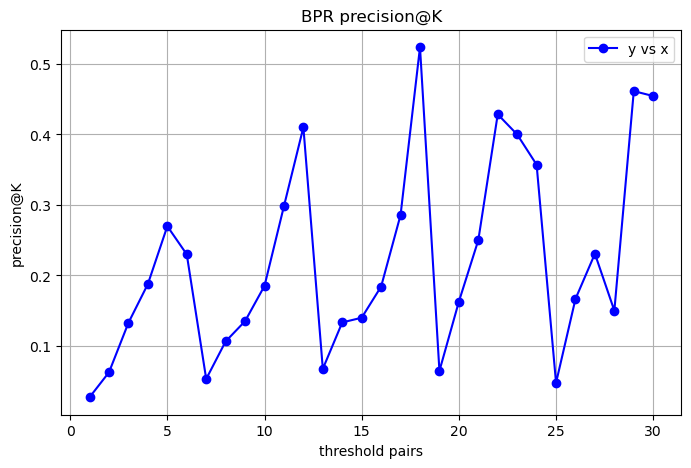

The max precision@K = 0.5238095238095238 for threshold_users = 30 and threshold_parents = 150


In [46]:
plt.figure(figsize=(8, 5))
plt.plot(list(range(1, len(threshold_users_list)*len(threshold_parents_list) + 1)), bpr_precisions, marker='o', linestyle='-', color='b', label='y vs x')
plt.xlabel('threshold pairs')
plt.ylabel('precision@K')
plt.title('BPR precision@K')
plt.legend()
plt.grid(True)
plt.show()
print(f"The max precision@K = {bpr_precisions[max_precision_index]} for threshold_users = {threshold_pairs[max_precision_index][0]} and threshold_parents = {threshold_pairs[max_precision_index][1]}")

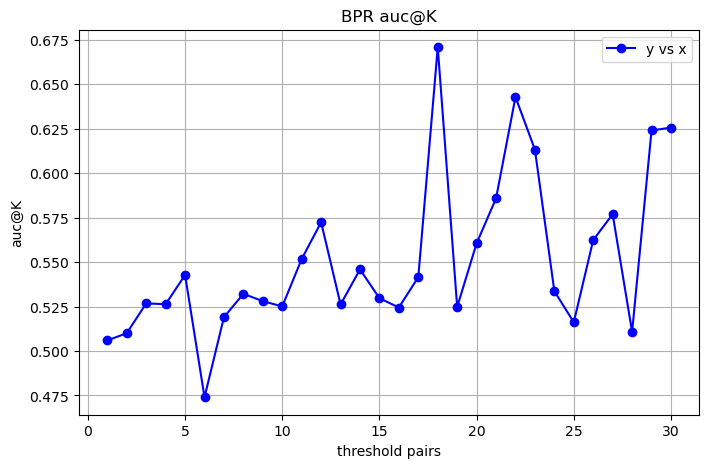

The max auc@K = 0.6708683473389355 for threshold_users = 30 and threshold_parents = 150


In [47]:
plt.figure(figsize=(8, 5))
plt.plot(list(range(1, len(threshold_users_list)*len(threshold_parents_list) + 1)), bpr_aucs, marker='o', linestyle='-', color='b', label='y vs x')
plt.xlabel('threshold pairs')
plt.ylabel('auc@K')
plt.title('BPR auc@K')
plt.legend()
plt.grid(True)
plt.show()
print(f"The max auc@K = {bpr_aucs[max_auc_index]} for threshold_users = {threshold_pairs[max_auc_index][0]} and threshold_parents = {threshold_pairs[max_auc_index][1]}")

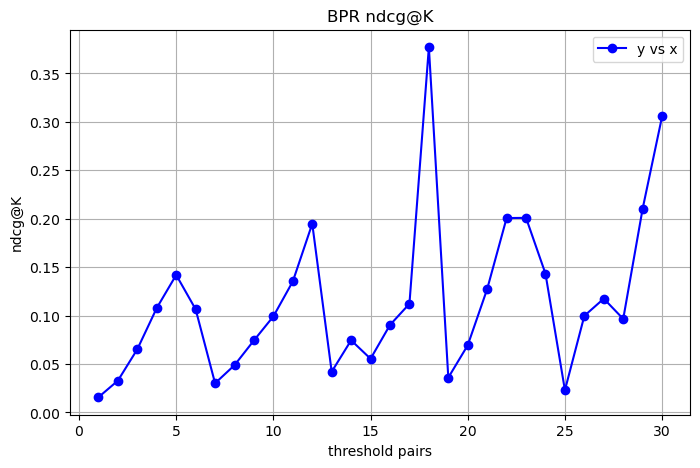

The max ndcg@K = 0.3770387380358511 for threshold_users = 30 and threshold_parents = 150


In [48]:
plt.figure(figsize=(8, 5))
plt.plot(list(range(1, len(threshold_users_list)*len(threshold_parents_list) + 1)), bpr_ndcgs, marker='o', linestyle='-', color='b', label='y vs x')
plt.xlabel('threshold pairs')
plt.ylabel('ndcg@K')
plt.title('BPR ndcg@K')
plt.legend()
plt.grid(True)
plt.show()
print(f"The max ndcg@K = {bpr_ndcgs[max_ndcg_index]} for threshold_users = {threshold_pairs[max_ndcg_index][0]} and threshold_parents = {threshold_pairs[max_ndcg_index][1]}")

### Although the matrix remains highly sparse, we see that there is improved reliability of the recommendations when we deal with frequent users and popular items. The trend of popular items is also observed among all 3 metrics, such that for every user threshold, we tend to see better scores for the more popular items (associated with more reviews). This aligns with our intuition that recommended items will tend to also be popular among users.

In [77]:
model = models[max_auc_index] # let us use the best AUC model

itemFactors = model.item_factors
userFactors = model.user_factors

uid0index = 2
recommended = model.recommend(uid0index, Xui_test[uid0index]) # Top k Recommendations for the user
print(recommended)

(array([ 7,  5, 15, 11,  4, 18, 13, 14, 29,  8]), array([0.14689182, 0.13283361, 0.10945462, 0.04968181, 0.04112147,
       0.03135332, 0.0183753 , 0.00978881, 0.00865201, 0.00735542],
      dtype=float32))


In [50]:
print(f"Inspecting items for user {uid0}")

Inspecting items for user AHQDYKP77D5ZFKU5TYD3TZWFLNTA


In [51]:
# Create an empty list for the recommended items
recommended_items = []

# Loop over each recommended ID
for recommendedId in recommended[0]:

    # Search for rows where the parent asin matches
    row = df_items[df_items["parent_asin"] == indexToParent[recommendedId]]

    # Append the rows to the recommended items list
    recommended_items.append(row)

# Concatonate the dataframes into a single frame
x = pd.concat(recommended_items, ignore_index=True)
print(len(x))

# Show the concatonated dataframe
x

10


main_category                                              title  \
0  Musical Instruments  D'Addario Guitar Strings - XL Nickel Electric ...   
1  Musical Instruments  GLS Audio Instrument Cable - Amp Cord for Bass...   
2  Musical Instruments  Donner Guitar Delay Pedal, Yellow Fall Analog ...   
3  Musical Instruments  D'Addario Accessories Guitar Tuner - Micro Hea...   
4  Musical Instruments  D'Addario Guitar Strings - Phosphor Bronze Aco...   
5  Musical Instruments  Ernie Ball Mondo Slinky Nickelwound Electric G...   
6  Musical Instruments  String Swing CC01K-BW Guitar Hanger and Guitar...   
7  Musical Instruments           DADDARIO 9-Volt Power Adaptor (PW-CT-9V)   
8  Musical Instruments  Singing Machine SMM-205P Unidirectional Dynami...   
9  Musical Instruments  KLIQ UberTuner-Max - Rechargable Professional ...   

   average_rating  rating_number  \
0             4.8          37890   
1             4.8          25245   
2             4.4          21461   
3             4.5          15961   
4             4.7          60133   
5             4.8         100615   
6             4.8          25422   
7             4.6          15012   
8             4.4          24634   
9             4.5          14578   

                                            features  \
0  [BESTSELLING SET – XL Nickel are our best-sell...   
1  [Durable: Built to last, our electric guitar c...   
2  [[Analog Delay Pedal] Reproduces the warm and ...   
3  [THE STEALTH TUNER - Your audience will never ...   
4  [CORROSION-RESISTANT, PRECISION WOUND – D’Adda...   
5  [Ernie Ball Slinkys are played by legends arou...   
6  [Deep cradle design that prevents the guitar f...   
7  [BATTERY FREE PERFORMANCE – You won’t need to ...   
8  [Country Of Origin : China, Wide Frequency Res...   
9  [ONE-OF-A-KIND OCTAVE TUNING. If you want to m...   

                                         description  price  \
0  [XL Nickel Wound electric guitar strings are t...   5.99   
1                                                 []   14.3   
2                                                 []  39.99   
3    [D'Addario Ns Micro Universal Tuner (PW-CT-13)]  18.99   
4  [D'Addario was the first to use Phosphor Bronz...  10.99   
5  [Product Description, Ernie Ball Mondo Slinkys...   6.99   
6                                                 []  14.99   
7                                                 []  10.99   
8  [Singing Machine Uni-Directional Microphone ha...  11.49   
9                                                 []  20.39   

                                              images  \
0  {'hi_res': ['https://m.media-amazon.com/images...   
1  {'hi_res': ['https://m.media-amazon.com/images...   
2  {'hi_res': ['https://m.media-amazon.com/images...   
3  {'hi_res': ['https://m.media-amazon.com/images...   
4  {'hi_res': ['https://m.media-amazon.com/images...   
5  {'hi_res': ['https://m.media-amazon.com/images...   
6  {'hi_res': ['https://m.media-amazon.com/images...   
7  {'hi_res': ['https://m.media-amazon.com/images...   
8  {'hi_res': ['https://m.media-amazon.com/images...   
9  {'hi_res': ['https://m.media-amazon.com/images...   

                                              videos                  store  \
0  {'title': ['D'Addario EXL120 Nickel Wound Elec...              D'Addario   
1  {'title': ['How the audio cable has held up to...              GLS Audio   
2  {'title': ['Love it! Instant creativity boost ...                 Donner   
3  {'title': ['D'Addario Accessories NS Micro Cli...  D'Addario Accessories   
4  {'title': ['D'Addario Phosphor Bronze Acoustic...              D'Addario   
5  {'title': ['Is It That Good? Ernie Ball Electr...             Ernie Ball   
6  {'title': ['String Swing Review', 'String Swin...           String Swing   
7            {'title': [], 'url': [], 'user_id': []}  D'Addario Accessories   
8  {'title': ['Perfect Microphone for Singing Due...        Singing Machine   
9  {'title': ['One of the best displays and su

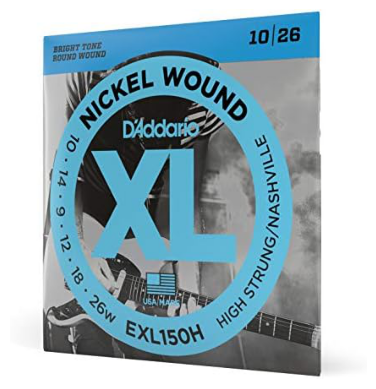

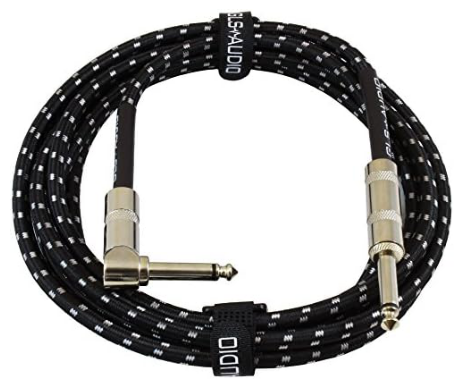

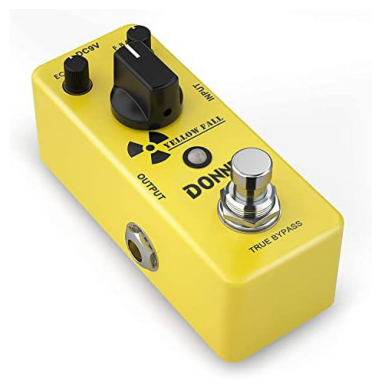

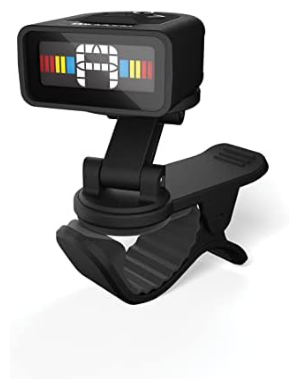

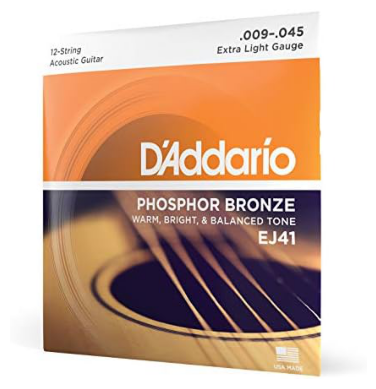

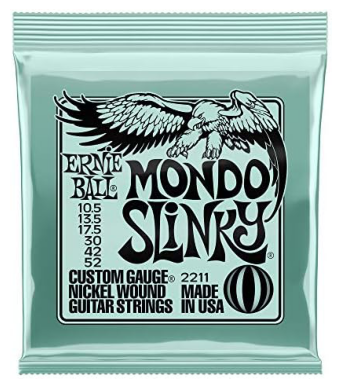

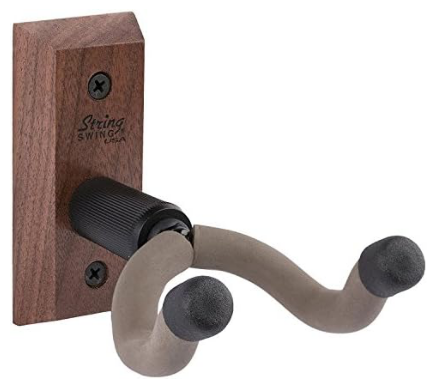

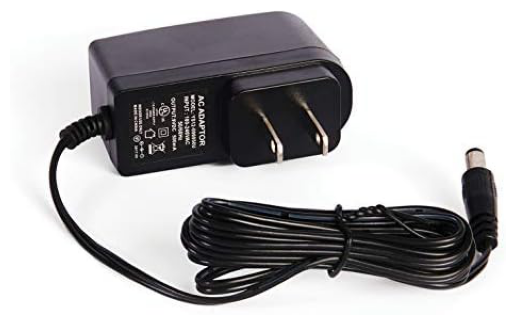

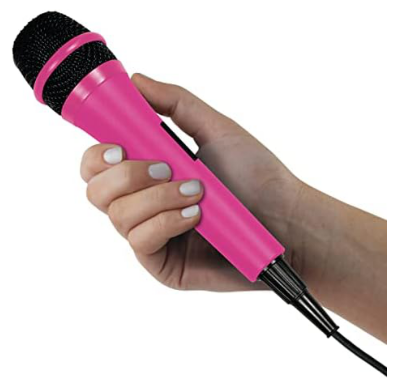

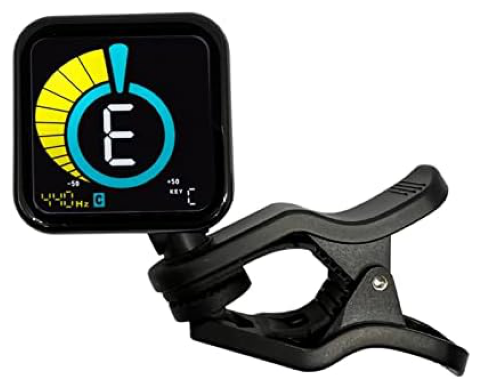

In [52]:
# show the images of the recommended items
def show_images(dataset):
    image_urls = []
    # URL of the image
    for img in dataset["images"]:
        for large_image in img["large"][:1]: # show 2 images of each item that is recommended
            image_urls.append(large_image)

    for url in image_urls:
        # Fetch and display the image
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        # Display the image inline
        plt.imshow(img)
        plt.axis('off')  # Turn off axis labels
        plt.show()

show_images(x)

In [70]:
indexOfRelatedItem = 4
related = model.similar_items(indexOfRelatedItem) # Top 10 Highly similar to the 5th item (using cosine similarity)
print(related) # shows the index of the similar item and the similarity score (sorted from best to least)

(array([ 4, 13, 14, 30, 11, 28,  6,  8, 18, 34]), array([0.9999998 , 0.96746343, 0.65050685, 0.5524331 , 0.5361241 ,
       0.50912917, 0.37285388, 0.32711124, 0.18656921, 0.15683867],
      dtype=float32))


            main_category                                              title  \
3252  Musical Instruments  D'Addario Guitar Strings - Phosphor Bronze Aco...   

      average_rating  rating_number  \
3252             4.7          60133   

                                               features  \
3252  [CORROSION-RESISTANT, PRECISION WOUND – D’Adda...   

                                            description  price  \
3252  [D'Addario was the first to use Phosphor Bronz...  10.99   

                                                 images  \
3252  {'hi_res': ['https://m.media-amazon.com/images...   

                                                 videos      store  \
3252  {'title': ['D'Addario Phosphor Bronze Acoustic...  D'Addario   

                                             categories  \
3252  [Musical Instruments, Instrument Accessories, ...   

                                                details parent_asin  \
3252  {"Item Weight": "1.4 ounces", "Product Dimensi...  B

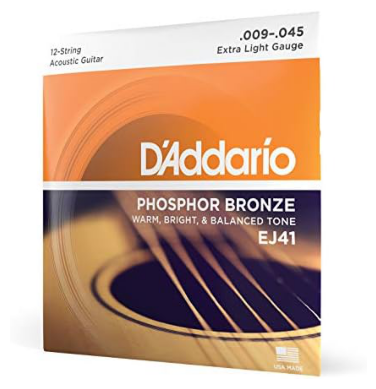

In [71]:
# What is the 5th item?
x = df_items[df_items["parent_asin"] == indexToParent[indexOfRelatedItem]]
print(x)
show_images(x)

In [72]:
# Create an empty list for the related items
related_items = []

# Loop over the related ID's
for relatedId in related[0]:
    # Find the parent ASIN coresponding to the related item ID
    parent_asin = indexToParent[relatedId]

    # Find rows where the parent asin matches
    row = df_items[df_items["parent_asin"] == parent_asin]

    # Append the row items to the related items list
    related_items.append(row)

# Concatonate the dataframes into a single dataframe
x = pd.concat(related_items, ignore_index=True)
print(len(x))

# Print the concatonated dataframe
x

10


main_category                                              title  \
0  Musical Instruments  D'Addario Guitar Strings - Phosphor Bronze Aco...   
1  Musical Instruments  String Swing CC01K-BW Guitar Hanger and Guitar...   
2  Musical Instruments           DADDARIO 9-Volt Power Adaptor (PW-CT-9V)   
3  Musical Instruments  D'Addario Celluloid Guitar Picks - 10 Pack - G...   
4  Musical Instruments  D'Addario Accessories Guitar Tuner - Micro Hea...   
5  Musical Instruments  Elixir Strings 80/20 Bronze Acoustic Guitar St...   
6  Musical Instruments  On Stage XCG4 Velveteen Padded Tubular Guitar ...   
7  Musical Instruments  KLIQ UberTuner-Max - Rechargable Professional ...   
8  Musical Instruments  Ernie Ball Mondo Slinky Nickelwound Electric G...   
9  Musical Instruments  Neewer Microphone Arm Stand, Suspension Boom S...   

   average_rating  rating_number  \
0             4.7          60133   
1             4.8          25422   
2             4.6          15012   
3             4.7          25159   
4             4.5          15961   
5             4.8          29394   
6             4.7          18219   
7             4.5          14578   
8             4.8         100615   
9             4.3          23418   

                                            features  \
0  [CORROSION-RESISTANT, PRECISION WOUND – D’Adda...   
1  [Deep cradle design that prevents the guitar f...   
2  [BATTERY FREE PERFORMANCE – You won’t need to ...   
3  [LIGHT GUITAR PICK: Light gauge (50mm) ideal f...   
4  [THE STEALTH TUNER - Your audience will never ...   
5  [Acoustic guitar strings constructed with 80/2...   
6  [Flush end caps to protect your instrument, Se...   
7  [ONE-OF-A-KIND OCTAVE TUNING. If you want to m...   
8  [Ernie Ball Slinkys are played by legends arou...   
9  [【Adjustable Microphone Boom Arm】 Conveniently...   

                                         description  price  \
0  [D'Addario was the first to use Phosphor Bronz...  10.99   
1                                                 []  14.99   
2                                                 []  10.99   
3  [Product Description, One of the first polymer...   8.61   
4    [D'Addario Ns Micro Universal Tuner (PW-CT-13)]  18.99   
5  [Prolong your tone with the same acoustic guit...  15.99   
6  [Our best seller combines our special formula ...  38.95   
7                                                 []  20.39   
8  [Product Description, Ernie Ball Mondo Slinkys...   6.99   
9                                                 []  16.99   

                                              images  \
0  {'hi_res': ['https://m.media-amazon.com/images...   
1  {'hi_res': ['https://m.media-amazon.com/images...   
2  {'hi_res': ['https://m.media-amazon.com/images...   
3  {'hi_res': ['https://m.media-amazon.com/images...   
4  {'hi_res': ['https://m.media-amazon.com/images...   
5  {'hi_res': ['https://m.media-amazon.com/images...   
6  {'hi_res': [None], 'large': ['https://m.media-...   
7  {'hi_res': ['https://m.media-amazon.com/images...   
8  {'hi_res': ['https://m.media-amazon.com/images...   
9  {'hi_res': ['https://m.media-amazon.com/images...   

                                              videos                  store  \
0  {'title': ['D'Addario Phosphor Bronze Acoustic...              D'Addario   
1  {'title': ['String Swing Review', 'String Swin...           String Swing   
2            {'title': [], 'url': [], 'user_id': []}  D'Addario Accessories   
3  {'title': ['CC CAIHONG Guitar picks review', '...              D'Addario   
4  {'title': ['D'Addario Accessories NS Micro Cli...  D'Addario Accessories   
5  {'title': ['Whats The Difference Between Strin...                 Elixir   
6  {'title': ['Pro Touring Musician Reviews On-St...                OnStage   
7  {'title': ['One of the best displays and super...        KLIQ Music Gear   
8  {'title': ['Is It That Good? Ernie Ball Electr...             Ernie Ball   
9  {'title': ['Watch before you buy! Honest un

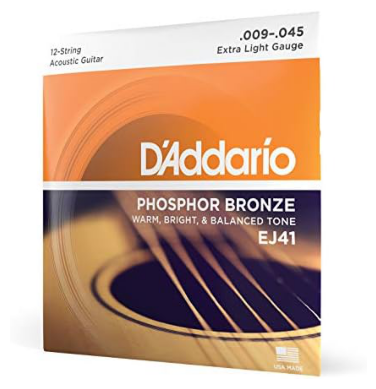

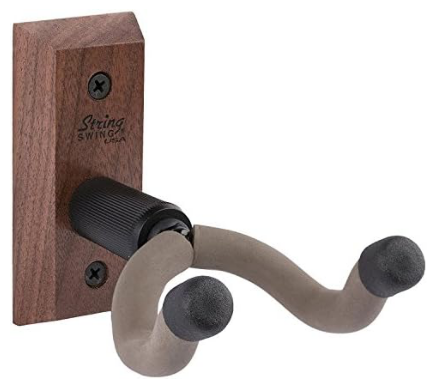

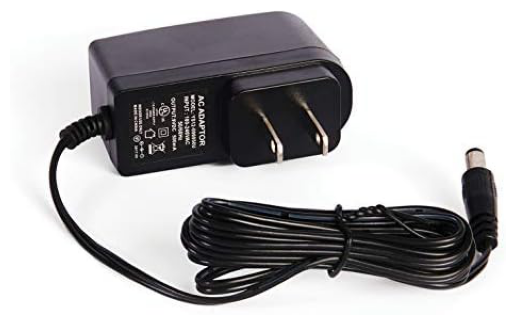

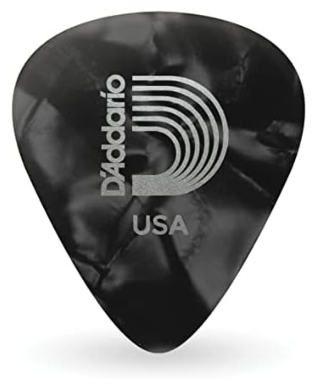

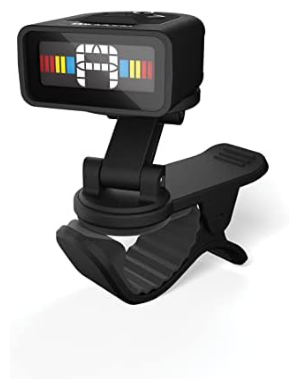

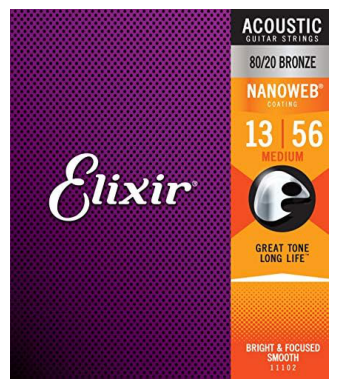

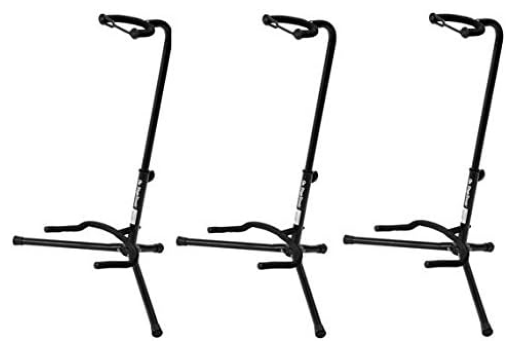

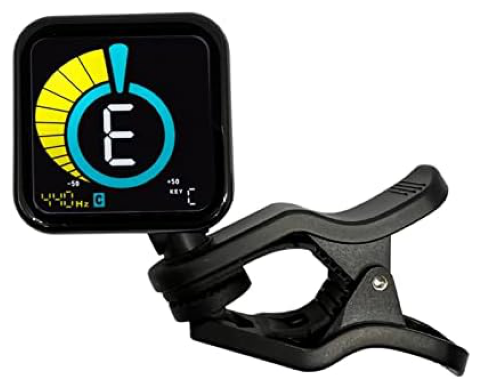

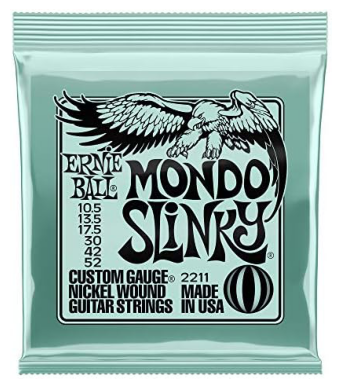

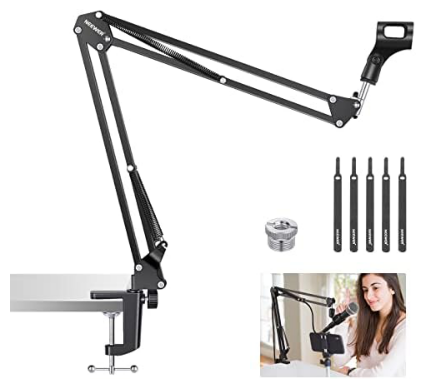

In [73]:
show_images(x)

# T4Rec: Transformer Based Recommendation

In [ ]:
# Modify the values of user_id and item_id in the dataframe
df["user_id"] = df["user_id"].apply(lambda x: f"user_{x}")
df["item_id"] = df["asin"].apply(lambda x: f"item_{x}")

In [ ]:
# Genarting a list of unique item ids
item_ids = df.item_id.unique()

# Counter is used to feed items to item_vocab
item_counter = Counter(item_ids)

# Generating vocabulary for items
# Start by creating a mapping for items (assign indices manually)
special_token = ''
item_vocab_stoi = {special_token: 0}  # Add special token at index 0
item_vocab_stoi.update({item: idx for idx, item in enumerate(item_ids, start=1)})

# Item to title mapping dictionary
item_title_dict = dict(zip(df.item_id, df.title))

# Similarly generating a vocabulary for user ids
user_ids = df['user_id'].unique()
user_counter = Counter(user_ids)

# Generate vocabulary for users
user_vocab_stoi = {special_token: 0}  # Add special token at index 0
user_vocab_stoi.update({user: idx for idx, user in enumerate(user_ids, start=1)})

# Reverse mapping (index to user) if needed
user_vocab_itos = {idx: user for user, idx in user_vocab_stoi.items()}

In [ ]:
# Group ratings by user_id in order of increasing timestamp.
ratings_group = df.sort_values(by=["timestamp"]).groupby("user_id")

In [ ]:
# Create a new dataframe from the ratings_group data
ratings_data = pd.DataFrame(
    data={
        "user_id": list(ratings_group.groups.keys()),
        "item_id": list(ratings_group.item_id.apply(list)),
        "timestamps": list(ratings_group.timestamp.apply(list)),
    }
)

In [ ]:
# Sequence length, min history count and window slide size
sequence_length = 4
min_history = 1
step_size = 2

# Creating sequences from lists with sliding window
def create_sequences(values, window_size, step_size, min_history):
  sequences = []
  start_index = 0
  while len(values[start_index:]) > min_history:
    seq = values[start_index : start_index + window_size]
    sequences.append(seq)
    start_index += step_size
  return sequences

ratings_data.item_id = ratings_data.item_id.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size, min_history)
)

del ratings_data["timestamps"]

# Sub-sequences are exploded.
# Since there might be more than one sequence for each user.
ratings_data_transformed = ratings_data[["user_id", "item_id"]].explode(
    "item_id", ignore_index=True
)

# Remove rows where 'item_id' contains NaN or empty sequences
ratings_data_transformed = ratings_data_transformed.dropna(subset=['item_id'])
ratings_data_transformed = ratings_data_transformed[ratings_data_transformed['item_id'].apply(lambda x: isinstance(x, list) and len(x) > 0)]

ratings_data_transformed.rename(
    columns={"item_id": "sequence_item_id"},
    inplace=True,
)

In [ ]:
# Random indexing
random_selection = np.random.rand(len(ratings_data_transformed.index)) <= 0.85

# Split train data
df_train_data = ratings_data_transformed[random_selection]
train_data_raw = df_train_data[["user_id", "sequence_item_id"]].values

# Split test data
df_test_data = ratings_data_transformed[~random_selection]
test_data_raw = df_test_data[["user_id", "sequence_item_id"]].values


In [ ]:
# Pytorch Dataset for user interactions
class ItemSeqDataset(torch_ds):
    # Initialize dataset
    def __init__(self, data, item_vocab_stoi, user_vocab_stoi):
        self.data = data
        self.item_vocab_stoi = item_vocab_stoi
        self.user_vocab_stoi = user_vocab_stoi


    def __len__(self):
        return len(self.data)

    # Fetch data from the dataset
    def __getitem__(self, idx):
        user, item_sequence = self.data[idx]
        # Directly index into the vocabularies
        item_data = [self.item_vocab_stoi[item] for item in item_sequence]
        user_data = self.user_vocab_stoi[user]
        return torch.tensor(item_data), torch.tensor(user_data)


# Collate function and padding
def collate_batch(batch):
    item_list = [item[0] for item in batch]
    user_list = [item[1] for item in batch]
    return pad_sequence(item_list, padding_value=item_vocab_stoi[''], batch_first=True), torch.stack(user_list)


BATCH_SIZE = 256
# Create instances of your Dataset for each set
train_dataset = ItemSeqDataset(train_data_raw, item_vocab_stoi, user_vocab_stoi)
val_dataset = ItemSeqDataset(test_data_raw, item_vocab_stoi, user_vocab_stoi)
# Create DataLoaders
train_iter = torch_dl(train_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=collate_batch)
val_iter = torch_dl(val_dataset, batch_size=BATCH_SIZE,
                      shuffle=False, collate_fn=collate_batch)

# Create a PositionalEncoding class

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create a matrix shape
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


### Model Definition

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken: int, nuser: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        # positional encoder
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # Multihead attention mechanism.
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)

        # Embedding layers
        self.movie_embedding = nn.Embedding(ntoken, d_model)
        self.user_embedding = nn.Embedding(nuser, d_model)

        # Defining the size of the input to the model.
        self.d_model = d_model

        # Linear layer to map the output tomovie vocabulary.
        self.linear = nn.Linear(2*d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        # Initializing the weights of the embedding and linear layers.
        initrange = 0.1
        self.movie_embedding.weight.data.uniform_(-initrange, initrange)
        self.user_embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, user: Tensor, src_mask: Tensor = None) -> Tensor:
        # Embedding movie ids and userid
        movie_embed = self.movie_embedding(src) * math.sqrt(self.d_model)
        user_embed = self.user_embedding(user) * math.sqrt(self.d_model)

        # positional encoding
        movie_embed = self.pos_encoder(movie_embed)

        # generating output with final layers
        output = self.transformer_encoder(movie_embed, src_mask)

        # Expand user_embed tensor along the sequence length dimension
        user_embed = user_embed.expand(-1, output.size(1), -1)

        # Concatenate user embeddings with transformer output
        output = torch.cat((output, user_embed), dim=-1)

        output = self.linear(output)
        return output

In [ ]:
# size of vocabulary
ntokens = len(item_vocab_stoi)
# embedding dimension
nusers = len(user_vocab_stoi)
emsize = 128
# dimension of the feedforward network model
d_hid = 128
# number of ``nn.TransformerEncoderLayer``
nlayers = 2
# number of heads in ``nn.MultiheadAttention``
nhead = 2
# dropout probability
dropout = 0.2

# If cuda is available then send to GPU, else we use the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assign our model and send to the GPU
model = TransformerModel(ntokens, nusers, emsize, nhead, d_hid, nlayers, dropout).to(device)

criterion = nn.CrossEntropyLoss()
# learning rate
lr = 1.0
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
def train(model: nn.Module, train_iter, epoch) -> None:
    # Switch to training mode
    model.train()
    total_loss = 0.
    log_interval = 200
    start_time = time.time()

    for i, (item_data, user_data) in enumerate(train_iter):
        # Load movie sequence and user id
        item_data, user_data = item_data.to(device), user_data.to(device)
        user_data = user_data.reshape(-1, 1)

        # Split movie sequence to inputs and targets
        inputs, targets = item_data[:, :-1], item_data[:, 1:]
        targets_flat = targets.reshape(-1)

        # Predict movies
        output = model(inputs, user_data)
        output_flat = output.reshape(-1, ntokens)

        # Backpropogation process
        loss = criterion(output_flat, targets_flat)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        # Results
        if i % log_interval == 0 and i > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

In [ ]:
def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    # Switch the model to evaluation mode.
    # This is necessary for layers like dropout,
    model.eval()
    total_loss = 0.

    with torch.no_grad():
        for i, (item_data, user_data) in enumerate(eval_data):
            # Load item sequence and user id
            item_data, user_data = item_data.to(device), user_data.to(device)
            user_data = user_data.reshape(-1, 1)
            # Split item sequence to inputs and targets
            inputs, targets = item_data[:, :-1], item_data[:, 1:]
            targets_flat = targets.reshape(-1)
            # Predict item
            output = model(inputs, user_data)
            output_flat = output.reshape(-1, ntokens)
            # Calculate loss
            loss = criterion(output_flat, targets_flat)
            total_loss += loss.item()
    return total_loss / (len(eval_data) - 1)

In [ ]:
best_val_loss = float('inf')
epochs = 10

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()

        # Training
        train(model, train_iter, epoch)

        # Evaluation
        val_loss = evaluate(model, val_iter)

        # Compute the perplexity of the validation loss
        val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time

        # Results
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
            f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
        print('-' * 89)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_params_path)

        scheduler.step()
    model.load_state_dict(torch.load(best_model_params_path)) # load best model states

-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  6.64s | valid loss  8.42 | valid ppl  4548.52
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  5.46s | valid loss  8.34 | valid ppl  4207.28
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time:  5.11s | valid loss  8.20 | valid ppl  3652.30
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time:  5.27s | valid loss  8.19 | valid ppl  3607.91
--------------------------------------------------------------------------

<ipython-input-38-6292c2a5b908>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path)) # load best model states


In [ ]:
def get_popular_items(df_ratings):
  # Calculate the number of ratings for each item
  rating_counts = df['item_id'].value_counts().reset_index()
  rating_counts.columns = ['item_id', 'rating_count']

  # Get the most frequently rated items
  min_ratings_threshold = rating_counts['rating_count'].quantile(0.95)

  # Filter items based on the minimum number of ratings
  popular_items = df.merge(rating_counts, on='item_id')
  popular_items = popular_items[popular_items['rating_count'] >= min_ratings_threshold]

  # Calculate the average rating for each item
  average_ratings = popular_items.groupby('item_id')['rating'].mean().reset_index()

  # Get the top 10 rated items
  top_10_items = list(average_ratings.sort_values('rating', ascending=False).head(10).item_id.values)
  return top_10_items


In [ ]:
# A placeholders to store results of recommendations
transformer_reco_results = list()
popular_reco_results = list()

# Get top 10 items
k = 10
# Iterate over the validation data
for i, (item_data, user_data) in enumerate(val_iter):
    # Feed the input and get the outputs
    item_data, user_data = item_data.to(device), user_data.to(device)
    user_data = user_data.reshape(-1, 1)
    inputs, targets = item_data[:, :-1], item_data[:, 1:]
    output = model(inputs, user_data)
    output_flat = output.reshape(-1, ntokens)
    targets_flat = targets.reshape(-1)

    # Reshape the output_flat to get top predictions
    outputs = output_flat.reshape(output_flat.shape[0] // inputs.shape[1],
                                  inputs.shape[1],
                                  output_flat.shape[1])[: , -1, :]
    # k + inputs.shape[1] = 13 items obtained
    # In order to prevent to recommend already watched items
    values, indices = outputs.topk(k + inputs.shape[1], dim=-1)

    for sub_sequence, sub_indice_org in zip(item_data, indices):
        sub_indice_org = sub_indice_org.cpu().detach().numpy()
        sub_sequence = sub_sequence.cpu().detach().numpy()

        # Generate mask array to eliminate already watched item
        mask = np.isin(sub_indice_org, sub_sequence[:-1], invert=True)

        # After masking get top k items
        sub_indice = sub_indice_org[mask][:k]

        # Generate results array
        transformer_reco_result = np.isin(sub_indice, sub_sequence[-1]).astype(int)

        # Decode items to search in popular items
        if sub_sequence[-1] in item_vocab_stoi:
            target_item_decoded = item_vocab_stoi[sub_sequence[-1]]
        else:
            # Handle missing item (skip, set to default, etc.)
            target_item_decoded = None  # or some default value

        top_10_items = get_popular_items(df)

        popular_reco_result = np.isin(top_10_items, target_item_decoded).astype(int)

        transformer_reco_results.append(transformer_reco_result)
        popular_reco_results.append(popular_reco_result)


In [ ]:
from sklearn.metrics import ndcg_score

# Since we have already sorted our recommendations
# An array that represent our recommendation scores is used.
representative_array = [[i for i in range(k, 0, -1)]] * len(transformer_reco_results)

for k in [3, 5, 10]:
  transformer_result = ndcg_score(transformer_reco_results,
                                  representative_array, k=k)
  popular_result = ndcg_score(popular_reco_results,
                              representative_array, k=k)

  print(f"Transformer NDCG result at top {k}: {round(transformer_result, 4)}")
  print(f"Popular recommendation NDCG result at top {k}: {round(popular_result, 4)}\n\n")

Transformer NDCG result at top 3: 0.1702
Popular recommendation NDCG result at top 3: 0.0


Transformer NDCG result at top 5: 0.1717
Popular recommendation NDCG result at top 5: 0.0


Transformer NDCG result at top 10: 0.1736
Popular recommendation NDCG result at top 10: 0.0


